# <center><font color="green"> https://bit.ly/ptpjb-2021-10</font><br><font color="blue">10 - Time Series Analysis - Prophet</font></center>

<center><img alt="" src="images/cover_ptpjb_2021.png"/></center> 

## <center><font color="blue">tau-data Indonesia</font><br>(C) Taufik Sutanto - 2021</center>
<center><a href="https://tau-data.id">https://tau-data.id</a> ~ <a href="mailto:taufik@tau-data.id">taufik@tau-data.id</a></center>

# 10 - Time Series Analysis - Prophet

<img src="images/time series fbprophet.jpeg"  style="width: 500px;"/>

*Facebook Prophet library* adalah *open-source library* yang dirancang untuk membuat model forecasting pada dataset time series univariat (satu variabel). library ini dikembangkan oleh facebook dan dapat digunakan pada program R dan Python

fbprophet dapat mengimplementasikan model forecasting bahkan pada data time series yang mengandung tren, musiman, dan efek hari libur. library ini dirancang agar mudah digunakan dan secara otomatis dapat melakukan forecasting pada data time series. Sehingga dapat digunakan untuk internal perusahaan, seperti memperkirakan penjualan, kapasitas, dll.

**Sean J. Taylor, Ben Letham** : https://research.fb.com/blog/2017/02/prophet-forecasting-at-scale/

*Not all forecasting problems can be solved by the same procedure. Prophet is optimized for the business forecast tasks we have encountered at Facebook, which typically have any of the following characteristics:*

- hourly, daily, or weekly observations with at least a few months (preferably a year) of history
- strong multiple “human-scale” seasonalities: day of week and time of year
- important holidays that occur at irregular intervals that are known in advance (e.g. the Super Bowl)
- a reasonable number of missing observations or large outliers
- historical trend changes, for instance due to product launches or logging changes
- trends that are non-linear growth curves, where a trend hits a natural limit or saturates

## Prophet forecasting step-by-step

### Installing
Langkah pertama untuk menggunakan prophet adalah menginstallnya yang dapat dilakukan pada Command Prompt (Cmd) sebagai berikut:

`# bash`<br>
`# Install pystan with pip before using pip to install prophet`<br>
`# pystan>=3.0 is currently not supported`<br>
`pip install pystan==2.19.1.1`<br>
`pip install prophet`

In [1]:
# check prophet version
import prophet
# print version number
print('Prophet %s' % prophet.__version__)

Prophet 1.0


### Load Dataset (Car Sales Dataset)

Sebagai contoh kita akan gunakan data penjualan mobil bulanan selama 108 bulan. Data ini merupakan data time series univariat yang terdapat tren dan musiman.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [11]:
# load data
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = pd.read_csv(path, header=0)
# merubah tipe data object menjadi datetime
df['Month'] = pd.to_datetime(df['Month'])
# menjadikan kolom 'Month' sebagai index
df.set_index('Month', inplace=True) 
# summarize shape
print(df.shape)
# show first few rows
df.head()

(108, 1)


,Sales
Month,
1960-01-01,6550
1960-02-01,8728
1960-03-01,12026
1960-04-01,14395
1960-05-01,14587


Mari kita lihat plot dari data tersebut

<AxesSubplot:xlabel='Month'>

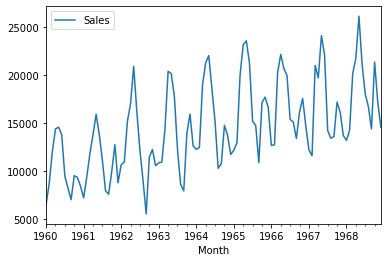

In [12]:
df.plot()

Kita dapat melihat dengan jelas tren penjualan dari waktu ke waktu dan pola musiman bulanan terhadap penjualan

### Membuat model forecasting dengan prophet
Untuk membuat model forecasting dengan prophet, kita harus membuat DataFrame dengan format berikut:
- Kolom pertama harus memiliki nama 'ds' dan berisi data tanggal/waktu.
- Kolom kedua harus memiliki nama 'y' dan berisi data yang diobservasi. 

In [14]:
# load data
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = pd.read_csv(path, header=0)

# mengganti nama kolom
df.columns = ['ds', 'y']

# merubah tipe data objek menjadi datetime
df['ds']= pd.to_datetime(df['ds'])

Kemudian membuat model forecasting dengan prophet sebagai berikut.

In [24]:
from prophet import Prophet

# define the model
model = Prophet()
# fit the model
model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Melihat performa model

1249.2528643972837


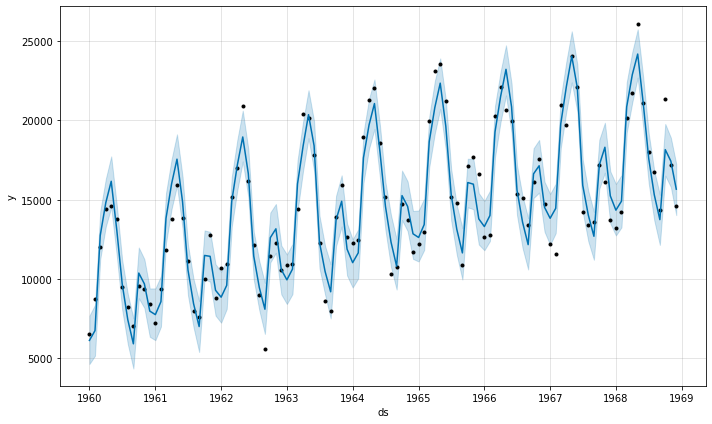

In [30]:
predict = model.predict(df)
model.plot(predict);

from sklearn.metrics import mean_squared_error as mse
rmse = np.sqrt(mse(df.y,predict.yhat))
print(rmse)

### Melakukan forecasting
setelah model berhasil dibuat, kita lakukan forecasting sebagai berikut

In [36]:
future = model.make_future_dataframe(periods=12,freq='M', include_history=True)
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1960-01-01,9600.274043,4744.904587,7729.834768,9600.274043,9600.274043,-3464.315527,-3464.315527,-3464.315527,-3464.315527,-3464.315527,-3464.315527,0.0,0.0,0.0,6135.958515
1,1960-02-01,9704.265356,5240.730453,8301.175326,9704.265356,9704.265356,-2952.452083,-2952.452083,-2952.452083,-2952.452083,-2952.452083,-2952.452083,0.0,0.0,0.0,6751.813273
2,1960-03-01,9801.547552,11139.258424,14276.921605,9801.547552,9801.547552,2943.121970,2943.121970,2943.121970,2943.121970,2943.121970,2943.121970,0.0,0.0,0.0,12744.669521
3,1960-04-01,9905.538865,13332.103439,16286.669858,9905.538865,9905.538865,4911.905978,4911.905978,4911.905978,4911.905978,4911.905978,4911.905978,0.0,0.0,0.0,14817.444842
4,1960-05-01,10006.175619,14532.918938,17686.068462,10006.175619,10006.175619,6158.054189,6158.054189,6158.054189,6158.054189,6158.054189,6158.054189,0.0,0.0,0.0,16164.229808


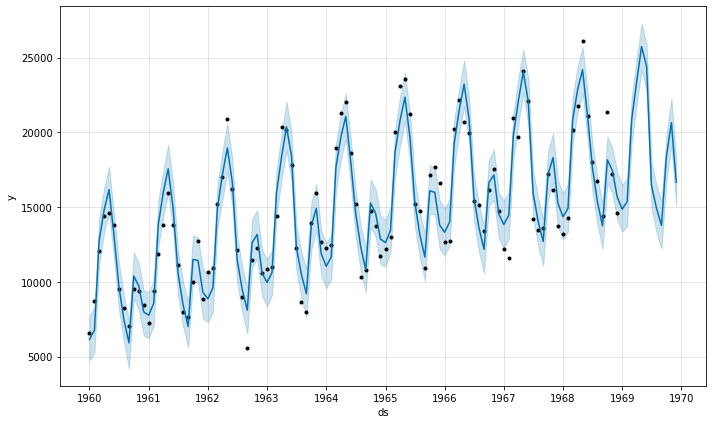

In [37]:
model.plot(forecast);

<AxesSubplot:xlabel='ds', ylabel='y'>

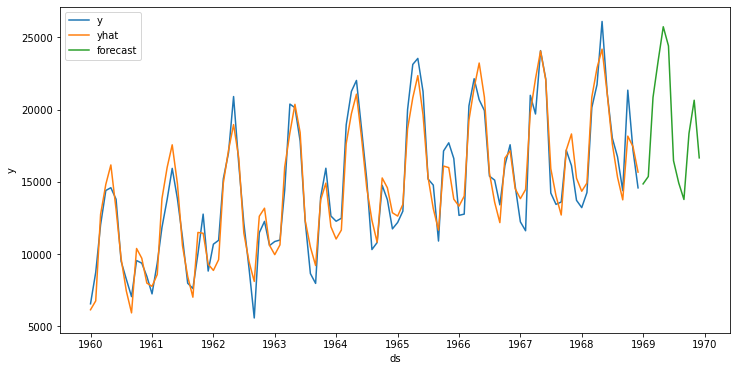

In [35]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df,x='ds', y='y', label = 'y')
sns.lineplot(data=predict,x='ds', y='yhat', label = 'yhat')
sns.lineplot(data=forecast,x='ds', y='yhat', label = 'forecast')

### Melihat tren dan musiman

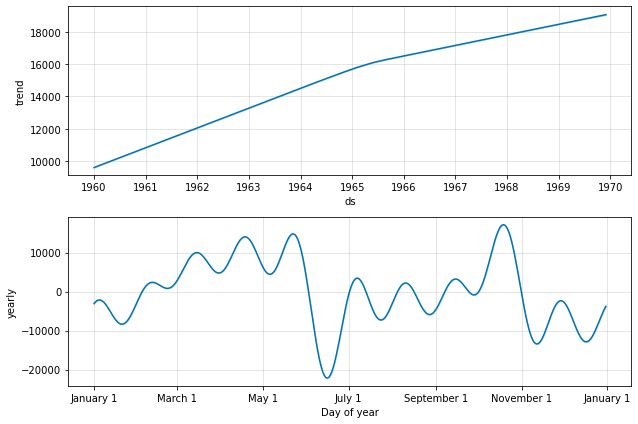

In [41]:
model.plot_components(forecast);

# <center><font color="blue"> Akhir Modul 10 - Time Series Analysis - Prophet</font></center>

<hr />
<img alt="" src="images/meme-cartoon/adsp-03-meme.png" style="height: 300px;"/>